In [1]:
%load_ext sympyprinting
%matplotlib inline
import matplotlib.pyplot as plt
import sympy
from IPython.display import display
sympy.init_printing(use_unicode=False, wrap_line=False, no_global=True)
import scipy.constants
import numpy as np

/home/ash/anaconda2/envs/python3/lib/python3.6/site-packages/IPython/extensions/sympyprinting.py:31: UserWarning: The sympyprinting extension has moved to `sympy`, use `from sympy import init_printing; init_printing()`
  warnings.warn("The sympyprinting extension has moved to `sympy`, "


# Equation of motion - SDE to be solved

### $\ddot{q}(t) + \Gamma_0\dot{q}(t) + \Omega_0^2 q(t) -  \dfrac{1}{m} F(t) = 0 $

#### where q = x, y or z

Where $F(t) = \mathcal{F}_{fluct}(t) + F_{feedback}(t)$

Taken from page 46 of 'Dynamics of optically levitated nanoparticles in high vacuum' - Thesis by Jan Gieseler 

Using $\mathcal{F}_{fluct}(t) = \sqrt{2m \Gamma_0 k_B T_0}\dfrac{dW(t)}{dt}$

and $F_{feedback}(t) = \Omega_0 \eta q^2 \dot{q}$

Taken from page 49 of 'Dynamics of optically levitated nanoparticles in high vacuum' - Thesis by Jan Gieseler 

we get the following SDE:

$\dfrac{d^2q(t)}{dt^2} + (\Gamma_0 - \Omega_0 \eta q(t)^2)\dfrac{dq(t)}{dt} + \Omega_0^2 q(t) - \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} = 0$

split into 2 first order ODE/SDE s

letting $v = \dfrac{dq}{dt}$

$\dfrac{dv(t)}{dt} + (\Gamma_0 - \Omega_0 \eta q(t)^2)v + \Omega_0^2 q(t) - \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} = 0$

therefore

$\dfrac{dv(t)}{dt} = -(\Gamma_0 - \Omega_0 \eta q(t)^2)v - \Omega_0^2 q(t) + \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} $

$v = \dfrac{dq}{dt}$ therefore $dq = v~dt$

\begin{align}
dq&=v\,dt\\
dv&=[-(\Gamma_0-\Omega_0 \eta q(t)^2)v(t) - \Omega_0^2 q(t)]\,dt + \sqrt{\frac{2\Gamma_0 k_B T_0}m}\,dW
\end{align}


### Apply Milstein Method to solve

Consider the autonomous Itō stochastic differential equation

${\mathrm  {d}}X_{t}=a(X_{t})\,{\mathrm  {d}}t+b(X_{t})\,{\mathrm  {d}}W_{t}$

Taking $X_t = q_t$ for the 1st equation above (i.e. $dq = v~dt$) we get:

$$ a(q_t) = v $$
$$ b(q_t) = 0 $$

Taking $X_t = v_t$ for the 2nd equation above (i.e. $dv = ...$) we get:

$$a(v_t) = -(\Gamma_0-\Omega_0\eta q(t)^2)v - \Omega_0^2 q(t)$$ 
$$b(v_t) = \sqrt{\dfrac{2\Gamma_0 k_B T_0}m}$$

${\displaystyle b'(v_{t})=0}$ therefore the diffusion term does not depend on ${\displaystyle v_{t}}$ , the Milstein's method in this case is therefore equivalent to the Euler–Maruyama method.

We then construct these functions in python:

In [2]:
def a_q(t, v, q):
    return v

def a_v(t, v, q):
    return -(Gamma0 - Omega0*eta*q**2)*v - Omega0**2*q

def b_v(t, v, q):
    return np.sqrt(2*Gamma0*k_b*T_0/m)


Using values obtained from fitting to data from a real particle we set the following constant values describing the system. Cooling has been assumed to be off by setting $\eta = 0$.

In [3]:
Gamma0 = 4000 # radians/second
Omega0 = 75e3*2*np.pi # radians/second
eta = 0.5e7
T_0 = 300 # K
k_b = scipy.constants.Boltzmann # J/K
m = 3.1e-19 # KG

partition the interval [0, T] into N equal subintervals of width $\Delta t>0$:
$ 0=\tau _{0}<\tau _{1}<\dots <\tau _{N}=T{\text{ with }}\tau _{n}:=n\Delta t{\text{ and }}\Delta t={\frac {T}{N}}$


In [4]:
dt = 1e-10
tArray = np.arange(0, 100e-6, dt)

In [5]:
print("{} Hz".format(1/dt))

10000000000.0 Hz


set $Y_{0}=x_{0}$

In [6]:
q0 = 0
v0 = 0
q = np.zeros_like(tArray)
v = np.zeros_like(tArray)
q[0] = q0
v[0] = v0

Generate independent and identically distributed normal random variables with expected value 0 and variance dt

In [7]:
np.random.seed(88)

dwArray = np.random.normal(0, np.sqrt(dt), len(tArray)) # independent and identically distributed normal random variables with expected value 0 and variance dt

Apply Milstein's method (Euler Maruyama if $b'(Y_{n}) = 0$ as is the case here):

recursively define $Y_{n}$ for $ 1\leq n\leq N $ by

$ Y_{{n+1}}=Y_{n}+a(Y_{n})\Delta t+b(Y_{n})\Delta W_{n}+{\frac  {1}{2}}b(Y_{n})b'(Y_{n})\left((\Delta W_{n})^{2}-\Delta t\right)$

Perform this for the 2 first order differential equations:

In [8]:
#%%timeit

for n, t in enumerate(tArray[:-1]):
    dw = dwArray[n]
    v[n+1] = v[n] + a_v(t, v[n], q[n])*dt + b_v(t, v[n], q[n])*dw + 0
    q[n+1] = q[n] + a_q(t, v[n], q[n])*dt + 0


We now have an array of positions, $v$, and velocities $p$ with time $t$.

Text(0, 0.5, 'v')

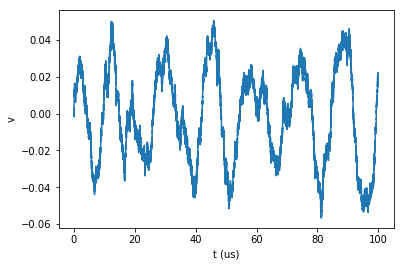

In [9]:
plt.plot(tArray*1e6, v)
plt.xlabel("t (us)")
plt.ylabel("v")

Text(0, 0.5, 'q')

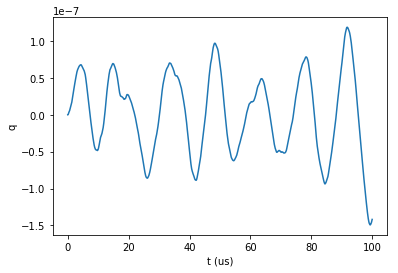

In [10]:
plt.plot(tArray*1e6, q)
plt.xlabel("t (us)")
plt.ylabel("q")

## Alternative multiple stage Runge-Kutta method

The previously used Euler-Maruyama method is a simple generalization of the Euler method for ordinary differential equations to stochastic differential equations. It is a relatively simple, unsophisticated method that requires small timesteps relative to the timescale of the dynamics to work correctly.

A more sophisticated alternative method we can use is a derivative-free version of Milsteins method as a two-stage kind-of Runge-Kutta method, documented in [wikipedia](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_%28SDE%29) or from the original paper deriving the method on [arxiv](https://arxiv.org/pdf/1210.0933.pdf).

In [11]:
q0 = 0
v0 = 0
X = np.zeros([len(tArray), 2])
X[0, 0] = q0
X[0, 1] = v0

In [12]:
def a(t, X):
    q, v = X
    return np.array([v, -(Gamma0 - Omega0*eta*q**2)*v - Omega0**2*q])

def b(t, X):
    q, v = X
    return np.array([0, np.sqrt(2*Gamma0*k_b*T_0/m)])

In [19]:
len(tArray)

In [22]:
#%%timeit

S = np.random.choice([-1, 1], len(tArray)) # randomly choose -1 or 1 with 50% chance
for n, t in enumerate(tArray[:-1]):
    dw = dwArray[n]
    K1 = a(t, X[n])*dt + b(t, X[n])*(dw - S[n]*np.sqrt(dt))
    Xh = X[n] + K1
    K2 = a(t, Xh)*dt + b(t, Xh)*(dw + S[n]*np.sqrt(dt))
    X[n+1] = X[n] + 0.5 * (K1+K2)


In [23]:
q = X[:, 0]
v = X[:, 1]

Text(0, 0.5, 'v')

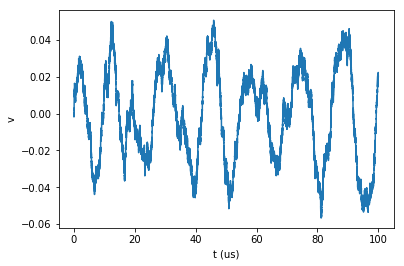

In [24]:
plt.plot(tArray*1e6, v)
plt.xlabel("t (us)")
plt.ylabel("v")

Text(0, 0.5, 'q')

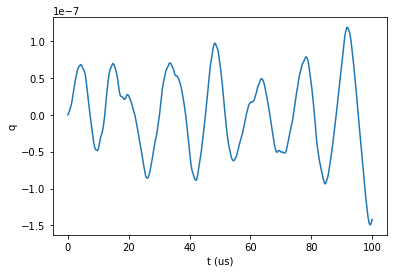

In [25]:
plt.plot(tArray*1e6, q)
plt.xlabel("t (us)")
plt.ylabel("q")

The form of $F_{feedback}(t)$ is still questionable

On page 49 of 'Dynamics of optically levitated nanoparticles in high vacuum' - Thesis by Jan Gieseler he uses the form: $F_{feedback}(t) = \Omega_0 \eta q^2 \dot{q}$

On page 2 of 'Parametric feeedback cooling of levitated optomechancs in a parabolic mirror trap' Paper by Jamie and Muddassar they use the form: $F_{feedback}(t) = \dfrac{\Omega_0 \eta q^2 \dot{q}}{q_0^2}$ where $q_0$ is the amplitude of the motion: $q(t) = q_0(sin(\omega_0t)$

However it always shows up as a term $\delta \Gamma$ like so:

$\dfrac{d^2q(t)}{dt^2} + (\Gamma_0 + \delta \Gamma)\dfrac{dq(t)}{dt} + \Omega_0^2 q(t) - \sqrt{\dfrac{2\Gamma_0 k_B T_0}{m}} \dfrac{dW(t)}{dt} = 0$

By fitting to data we extract the following 3 parameters:

1) $A = \gamma^2 \dfrac{k_B T_0}{\pi m}\Gamma_0 $

Where:

- $\gamma$ is the conversion factor between Volts and nanometres. This parameterises the amount of light/ number of photons collected from the nanoparticle. With unchanged allignment and the same particle this should remain constant with changes in pressure.
- $m$ is the mass of the particle, a constant
- $T_0$ is the temperature of the environment
- $\Gamma_0$ the damping due to the environment only

2) $\Omega_0$ - the natural frequency at this trapping power

3) $\Gamma$ - the total damping on the system including environment and feedback etc...

By taking a reference save with no cooling we have $\Gamma = \Gamma_0$ and therefore we can extract $A' = \gamma^2 \dfrac{k_B T_0}{\pi m}$. Since $A'$ should be constant with pressure we can therefore extract $\Gamma_0$ at any pressure (if we have a reference save and therefore a value of $A'$) and therefore can extract $\delta \Gamma$, the damping due to cooling, we can then plug this into our SDE instead in order to include cooling in the SDE model.

For any dataset at any pressure we can do:

$\Gamma_0 = \dfrac{A}{A'}$ 

And then $\delta \Gamma = \Gamma - \Gamma_0$

Using this form and the same derivation as above we arrive at the following form of the 2 1st order differential equations:

\begin{align}
dq&=v\,dt\\
dv&=[-(\Gamma_0 + \delta \Gamma)v(t) - \Omega_0^2 v(t)]\,dt + \sqrt{\frac{2\Gamma_0 k_B T_0}m}\,dW
\end{align}


In [26]:
def a_q(t, v, q):
    return v

def a_v(t, v, q):
    return -(Gamma0 + deltaGamma)*v - Omega0**2*q

def b_v(t, v, q):
    return np.sqrt(2*Gamma0*k_b*T_0/m)


values below are taken from a ~1e-2 mbar cooled save 

In [27]:
Gamma0 = 15 # radians/second
deltaGamma = 2200
Omega0 = 75e3*2*np.pi # radians/second
eta = 0.5e7
T_0 = 300 # K
k_b = scipy.constants.Boltzmann # J/K
m = 3.1e-19 # KG

In [28]:
dt = 1e-10
tArray = np.arange(0, 100e-6, dt)

In [29]:
q0 = 0
v0 = 0
q = np.zeros_like(tArray)
v = np.zeros_like(tArray)
q[0] = q0
v[0] = v0

In [30]:
np.random.seed(88)

dwArray = np.random.normal(0, np.sqrt(dt), len(tArray)) # independent and identically distributed normal random variables with expected value 0 and variance dt

In [31]:
for n, t in enumerate(tArray[:-1]):
    dw = dwArray[n]
    v[n+1] = v[n] + a_v(t, v[n], q[n])*dt + b_v(t, v[n], q[n])*dw + 0
    q[n+1] = q[n] + a_q(t, v[n], q[n])*dt + 0


Text(0, 0.5, 'v')

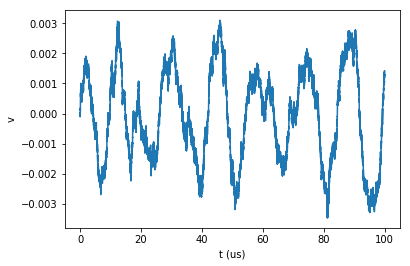

In [32]:
plt.plot(tArray*1e6, v)
plt.xlabel("t (us)")
plt.ylabel("v")

Text(0, 0.5, 'q')

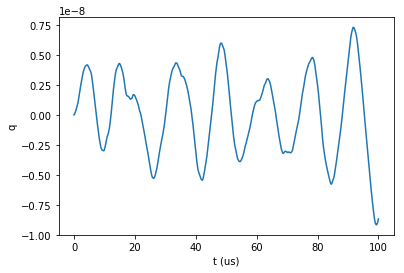

In [33]:
plt.plot(tArray*1e6, q)
plt.xlabel("t (us)")
plt.ylabel("q")